# Get Dataset

In [1]:
import kagglehub
import shutil
import os

# Download the dataset
source_path = kagglehub.dataset_download("gpiosenka/cards-image-datasetclassification")

# Target path: current working directory
target_path = os.path.join(os.getcwd(), "cards-image-dataset")

# Move the dataset to the current directory
shutil.copytree(source_path, target_path)

print("Dataset moved to:", target_path)


Dataset moved to: /content/cards-image-dataset


# Import Libraries

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm # PyTorch Image Models - a collection of state-of-the-art computer vision models, layers, utilities, optimizers, ...

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import sys
from tqdm.notebook import tqdm

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
PyTorch version 2.6.0+cu124
Torchvision version 0.21.0+cu124
Numpy version 2.0.2
Pandas version 2.2.2


# Pytorch Dataset (and Dataloader)

In [3]:
class CardsDataset(Dataset):
  def __init__(self, dataDir, transform=None):
    self.data = ImageFolder(dataDir, transform=transform)
  def __len__(self):
    return len(self.data)
  def __getitem__(self, index):
    return self.data[index]

  @property
  def classes(self):
    return self.data.classes

# See Dataset

In [15]:
dataset = CardsDataset(dataDir=f'{target_path}/train')

In [16]:
len(dataset)

7624

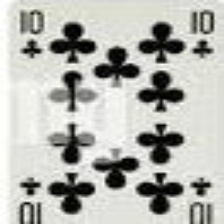

In [18]:
img, label = dataset[6000]
img

In [19]:
target_to_class = {v:k for k, v in ImageFolder(f'{target_path}/train').class_to_idx.items()}
target_to_class

{0: 'ace of clubs',
 1: 'ace of diamonds',
 2: 'ace of hearts',
 3: 'ace of spades',
 4: 'eight of clubs',
 5: 'eight of diamonds',
 6: 'eight of hearts',
 7: 'eight of spades',
 8: 'five of clubs',
 9: 'five of diamonds',
 10: 'five of hearts',
 11: 'five of spades',
 12: 'four of clubs',
 13: 'four of diamonds',
 14: 'four of hearts',
 15: 'four of spades',
 16: 'jack of clubs',
 17: 'jack of diamonds',
 18: 'jack of hearts',
 19: 'jack of spades',
 20: 'joker',
 21: 'king of clubs',
 22: 'king of diamonds',
 23: 'king of hearts',
 24: 'king of spades',
 25: 'nine of clubs',
 26: 'nine of diamonds',
 27: 'nine of hearts',
 28: 'nine of spades',
 29: 'queen of clubs',
 30: 'queen of diamonds',
 31: 'queen of hearts',
 32: 'queen of spades',
 33: 'seven of clubs',
 34: 'seven of diamonds',
 35: 'seven of hearts',
 36: 'seven of spades',
 37: 'six of clubs',
 38: 'six of diamonds',
 39: 'six of hearts',
 40: 'six of spades',
 41: 'ten of clubs',
 42: 'ten of diamonds',
 43: 'ten of hear

# Prepare Dataset

In [50]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = f'{target_path}/train'
valid_folder = f'{target_path}/valid'
test_folder = f'{target_path}/test'

train_dataset = CardsDataset(train_folder, transform=transform)
val_dataset = CardsDataset(valid_folder, transform=transform)
test_dataset = CardsDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [51]:
dataset = CardsDataset(dataDir=train_folder, transform=transform)

In [23]:
img, label = dataset[6000]
img.shape

torch.Size([3, 128, 128])

**Dataloaders**

Batching our data

In [27]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [35]:
for images, labels in dataloader:
  break

images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [29]:
labels

tensor([22,  8, 18,  6, 48,  9, 29,  2, 32, 28,  5, 45, 38, 49,  8, 32, 36,  4,
        21,  3, 25, 28, 11, 27,  5, 27,  6, 15, 18,  9, 51, 17])

# Model

In [37]:
class CardClassifier(nn.Module):
  def __init__(self, num_class=53):
    super(CardClassifier, self).__init__()
    # Define all the parts of the model
    self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
    self.features = nn.Sequential(*list(self.base_model.children())[:-1]) # Remove Last Layer

    enet_output_size = 1280
    self.classifier = nn.Linear(enet_output_size, num_class)


  def forward(self, x):
    # Forward Processing of the model
    x = self.features(x)
    output = self.classifier(x)
    return output

In [39]:
model = CardClassifier(num_class=53)
model

CardClassifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_p

In [40]:
output = model(images)
output.shape

torch.Size([32, 53])

# Loss Function

In [47]:
critrion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [48]:
critrion(output, labels)

tensor(4.0485, grad_fn=<NllLossBackward0>)

# Train The Model

In [58]:
num_epoch = 5

train_losses, val_losses = [], []

In [55]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

CardClassifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_p

In [59]:
for epoch in range(num_epoch):
  # Training phase
  model.train() # set the model to training mode
  running_loss = 0.0
  for images, labels in tqdm(train_loader, desc='Training loop'):
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad() # Clear old gradients

    outputs = model(images)

    loss = critrion(outputs, labels)

    loss.backward() # backpropagation — computes gradients of the loss with respect to model weights
    optimizer.step() # Updates the model parameters using the optimizer

    running_loss += loss.item() * labels.size(0) # Accumulate the loss for this batch, scaled by the number of examples in the batch

  train_loss = running_loss / len(train_loader.dataset)
  train_losses.append(train_loss)

  # Validation phase
  model.eval()
  running_loss = 0.0

  with torch.no_grad(): # Disables gradient calculations (saves memory and speeds up validation)
    for images, labels in tqdm(val_loader, desc='Validation loop'):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            loss = critrion(outputs, labels)

            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epoch} - Train loss: {train_loss}, Validation loss: {val_loss}")



Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 0.5307078372143749, Validation loss: 0.18047712051643516


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 0.33426836068895405, Validation loss: 0.1816883051732801


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 0.22118444713018248, Validation loss: 0.23667442978553052


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 0.2073129472427328, Validation loss: 0.10195932545751896


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 0.1380193922023708, Validation loss: 0.20684513978238375


# Visualize Losses

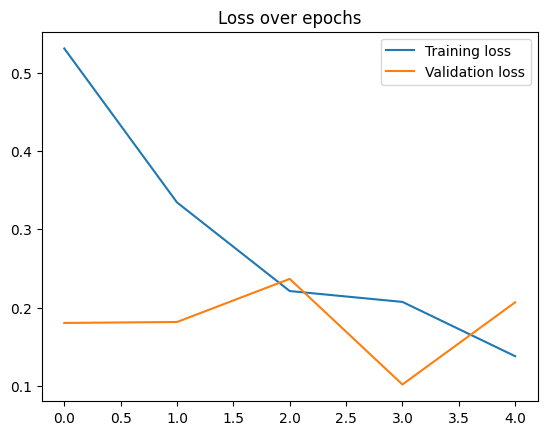

In [60]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

# Evaluating the Results

In [62]:
# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))

    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")

    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

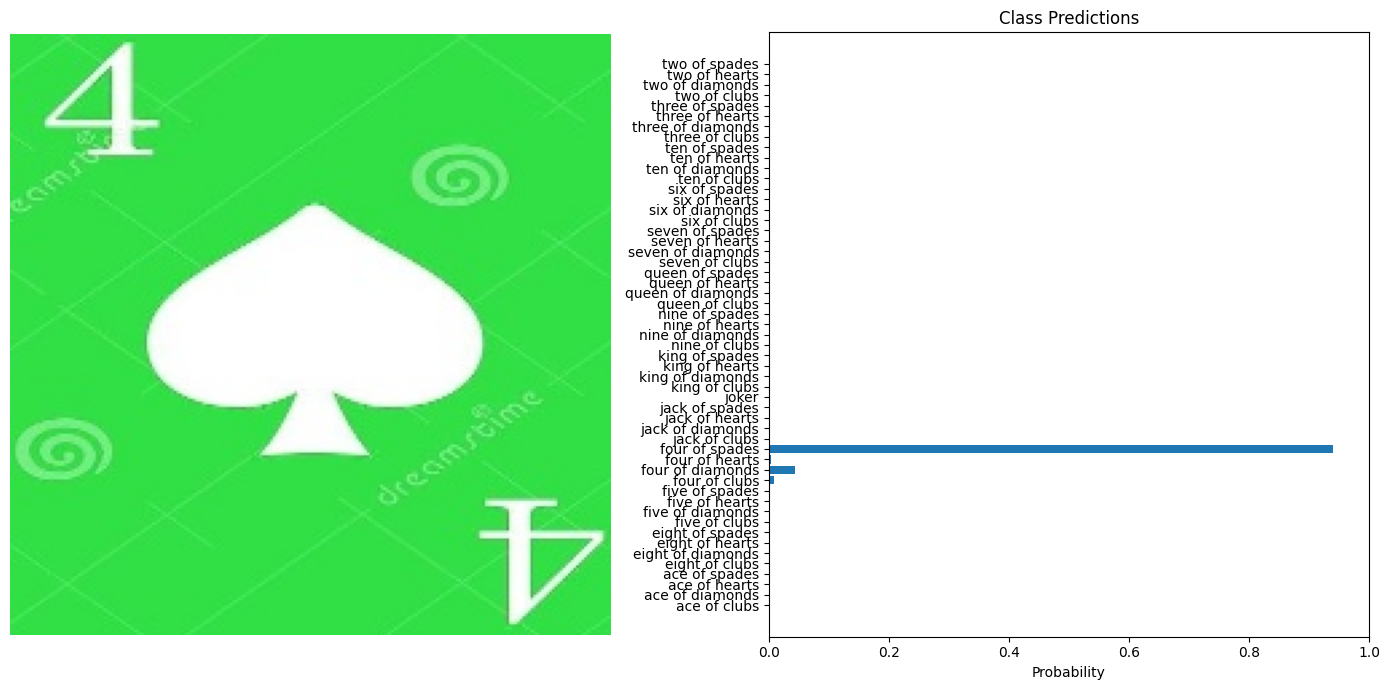

In [66]:
# Example usage
test_image = f"{test_folder}/four of spades/2.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes
visualize_predictions(original_image, probabilities, class_names)

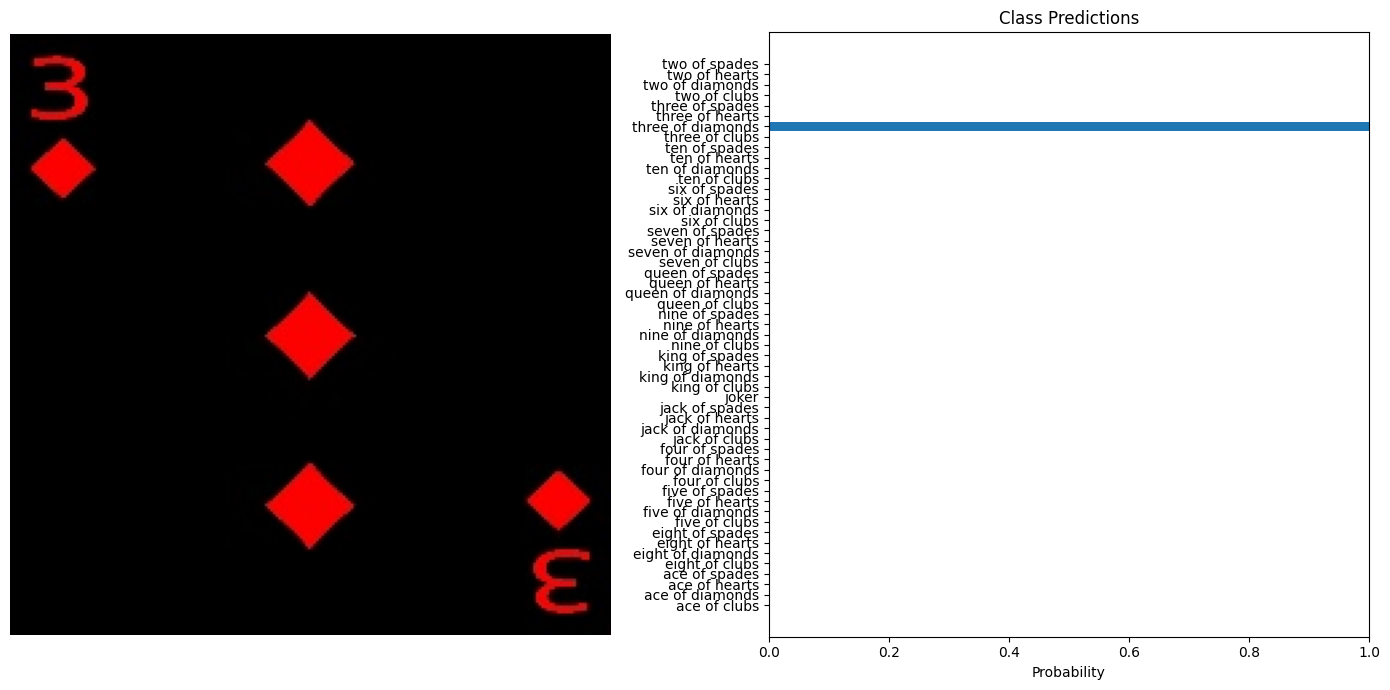

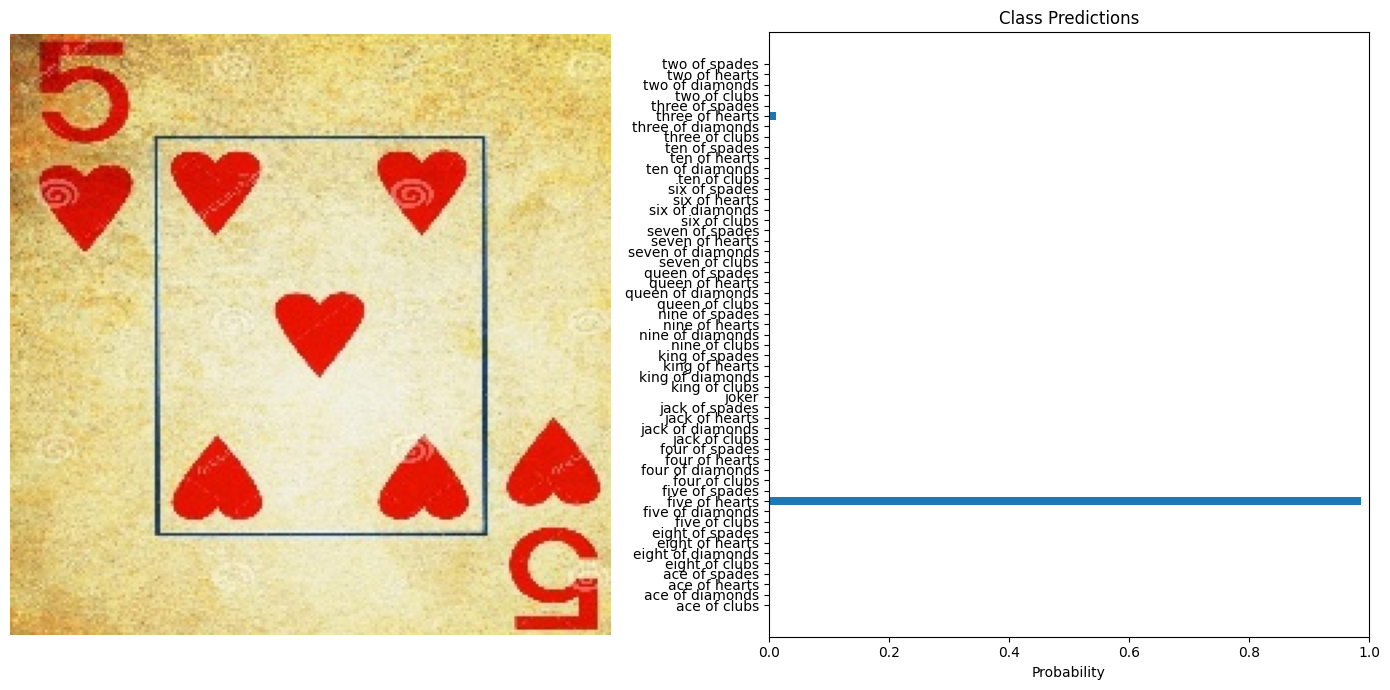

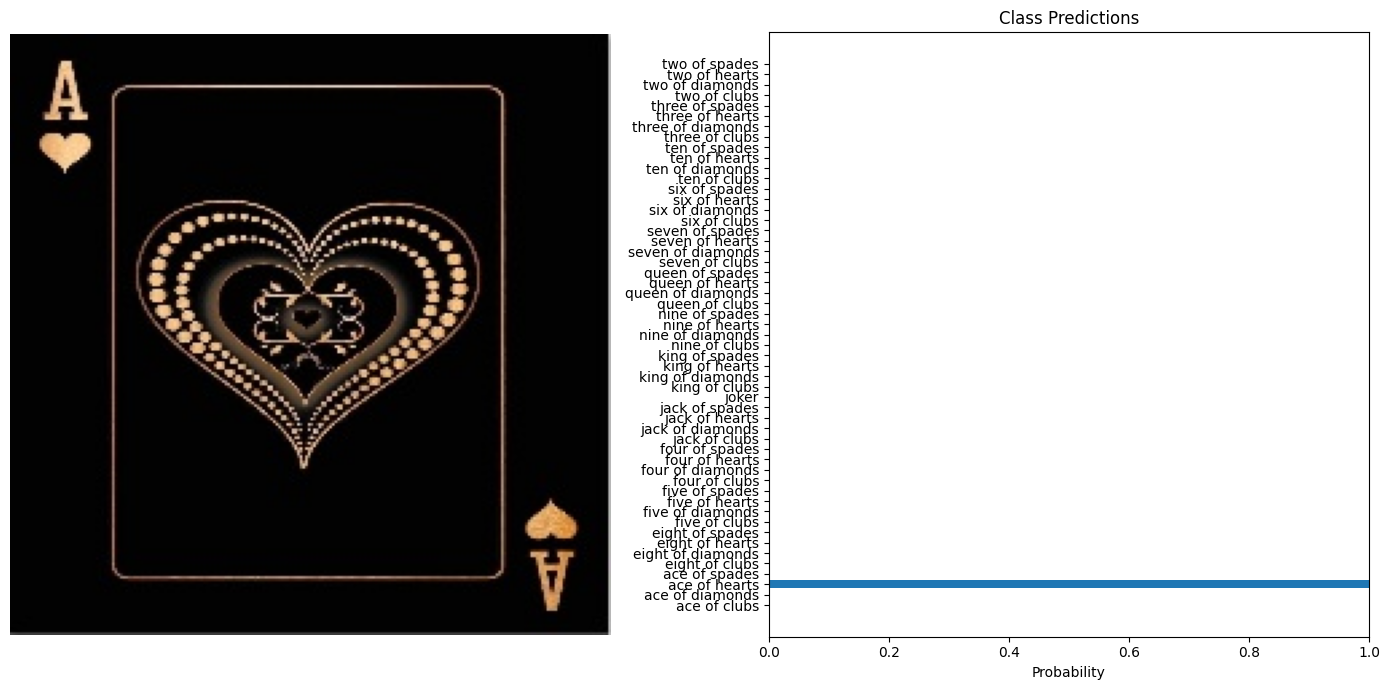

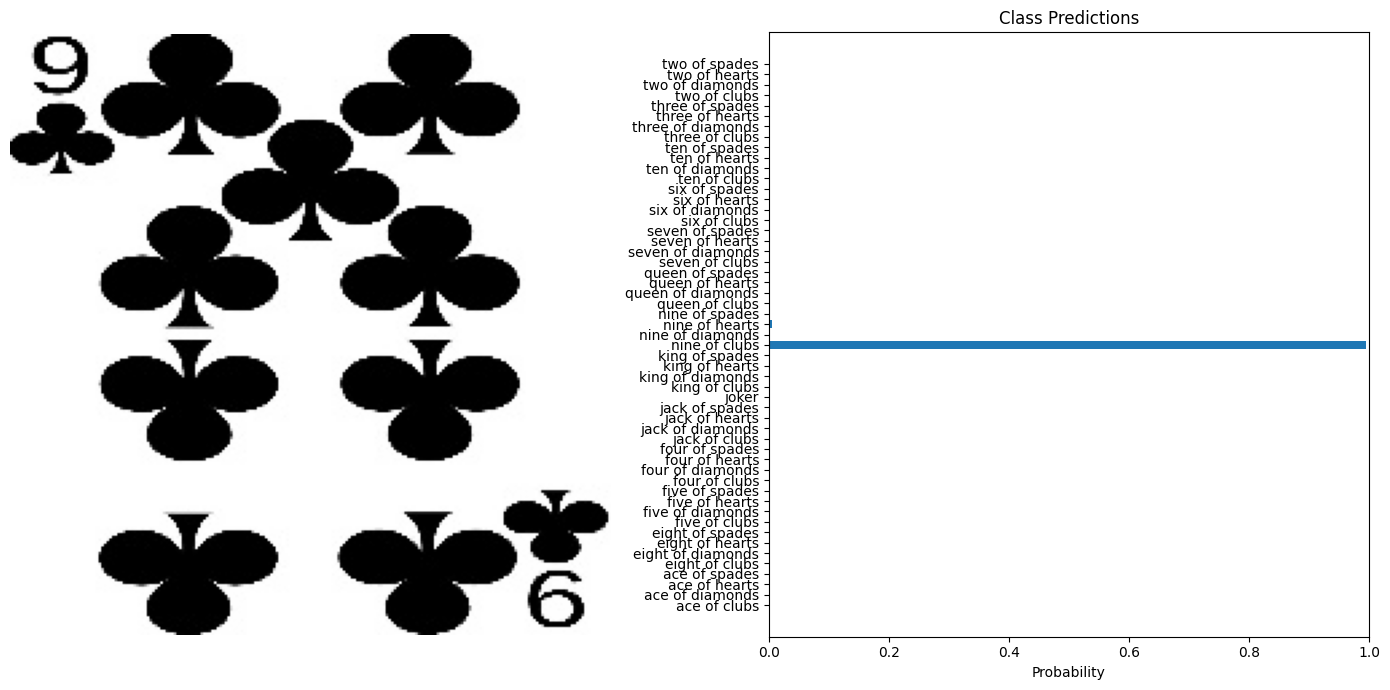

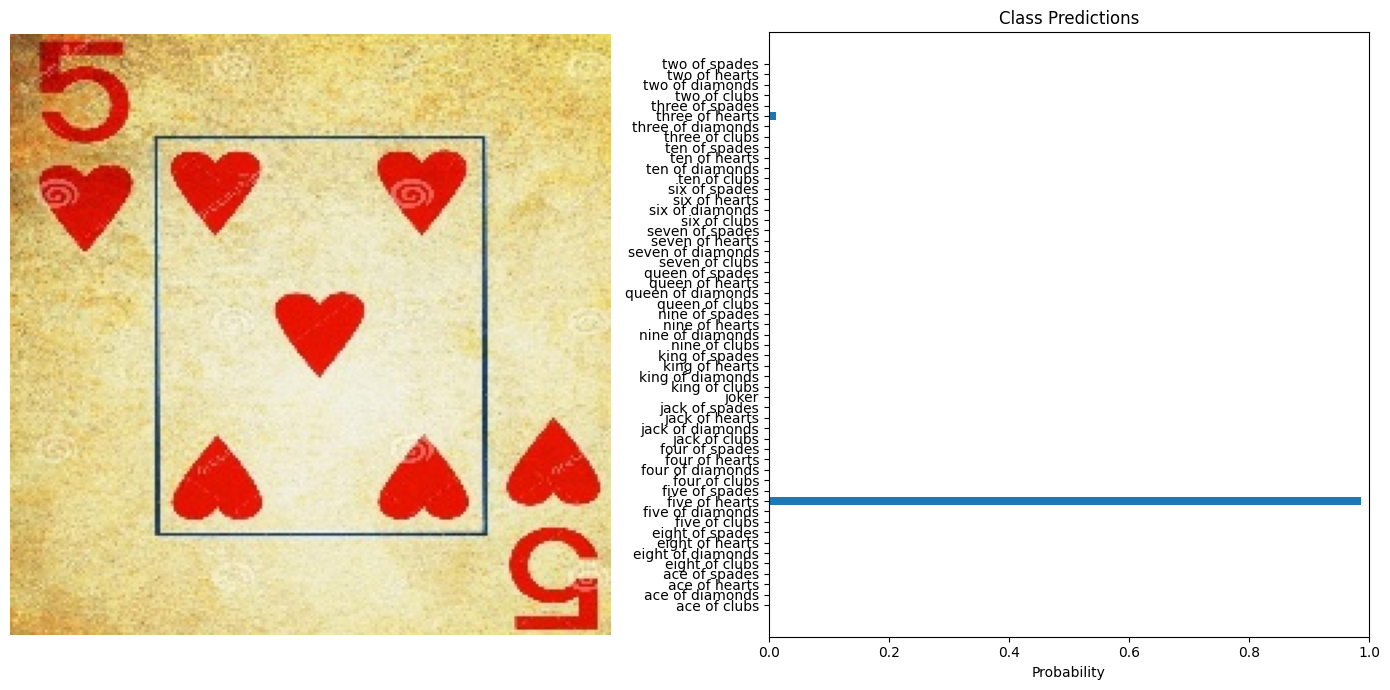

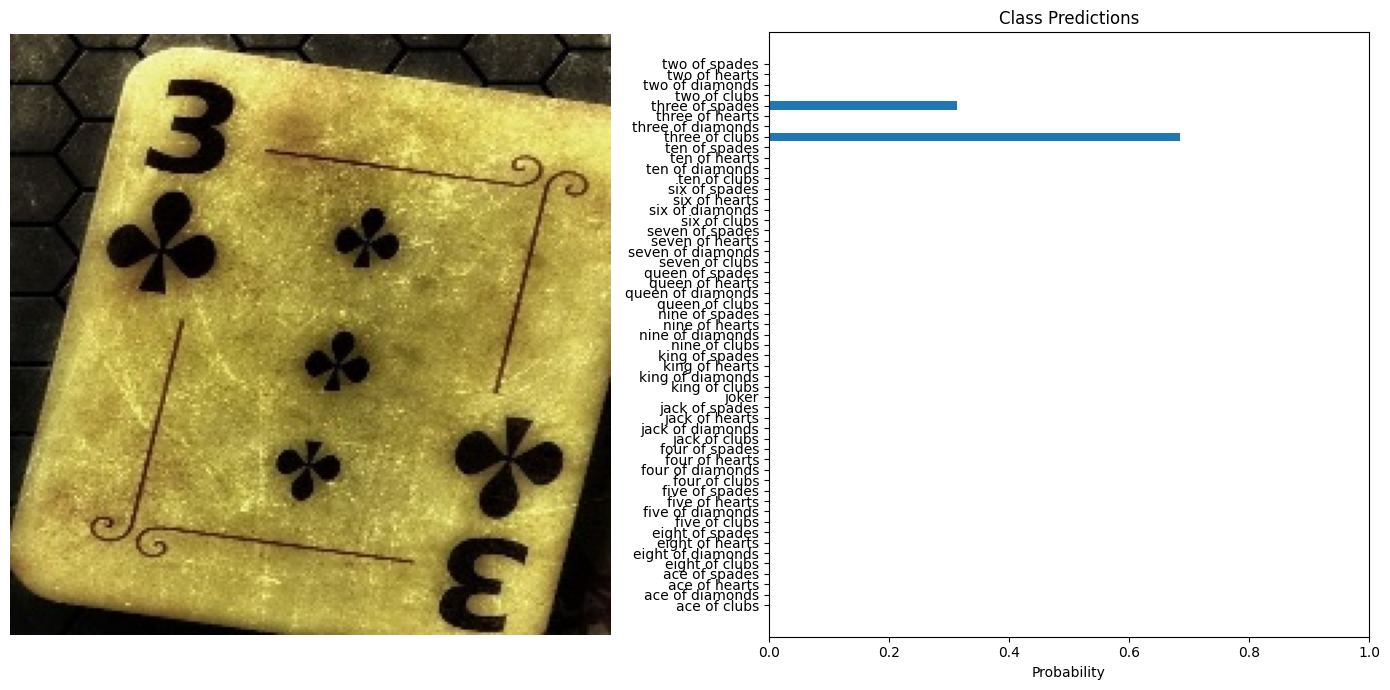

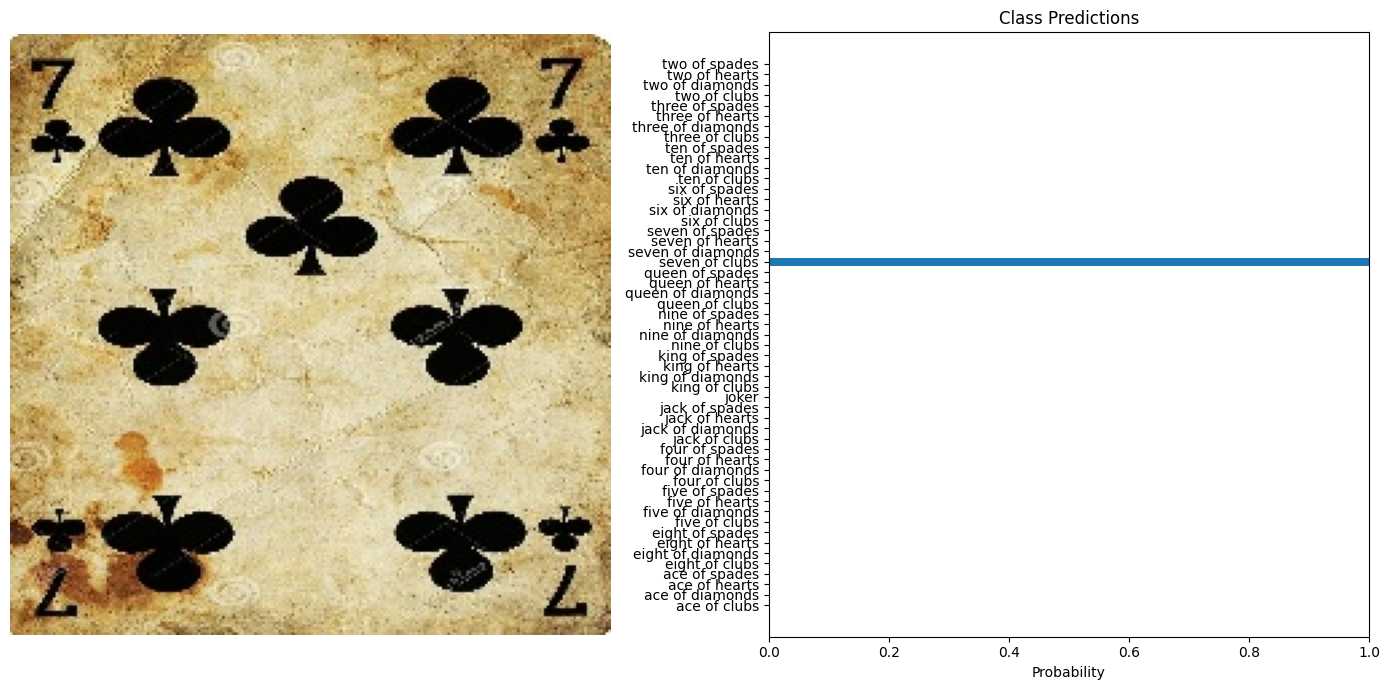

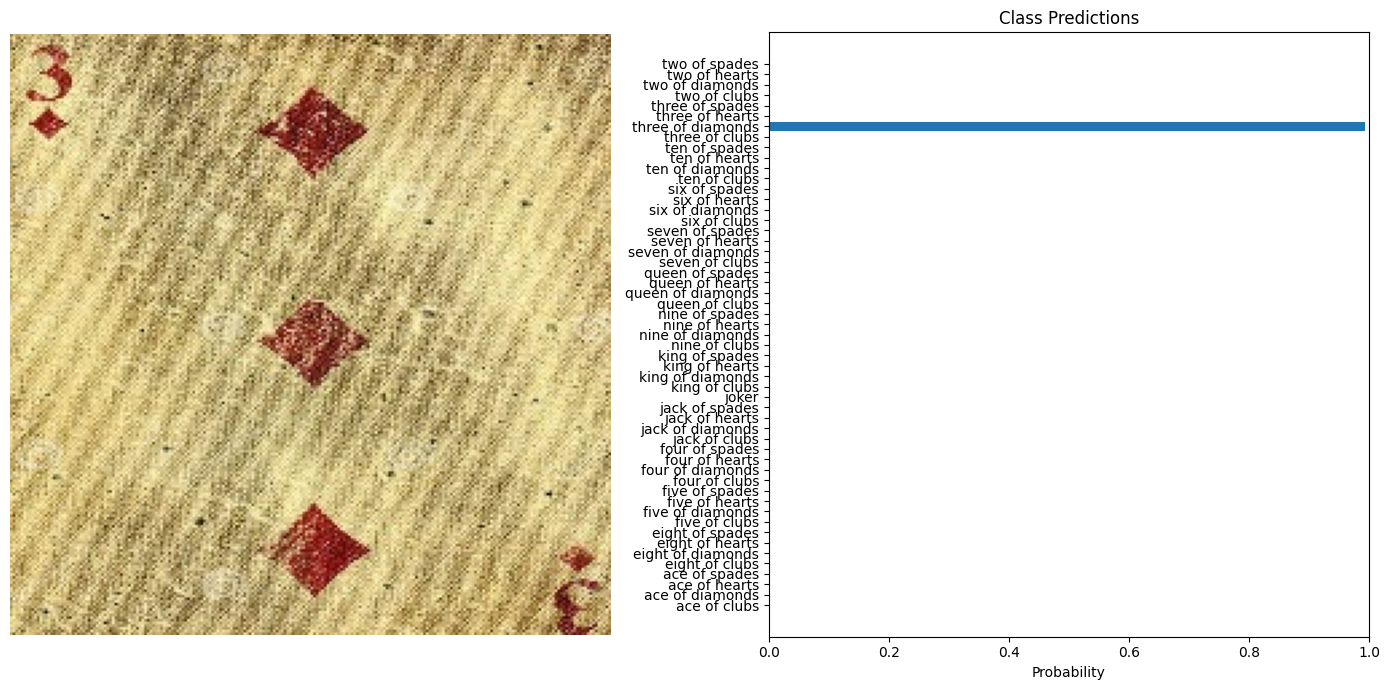

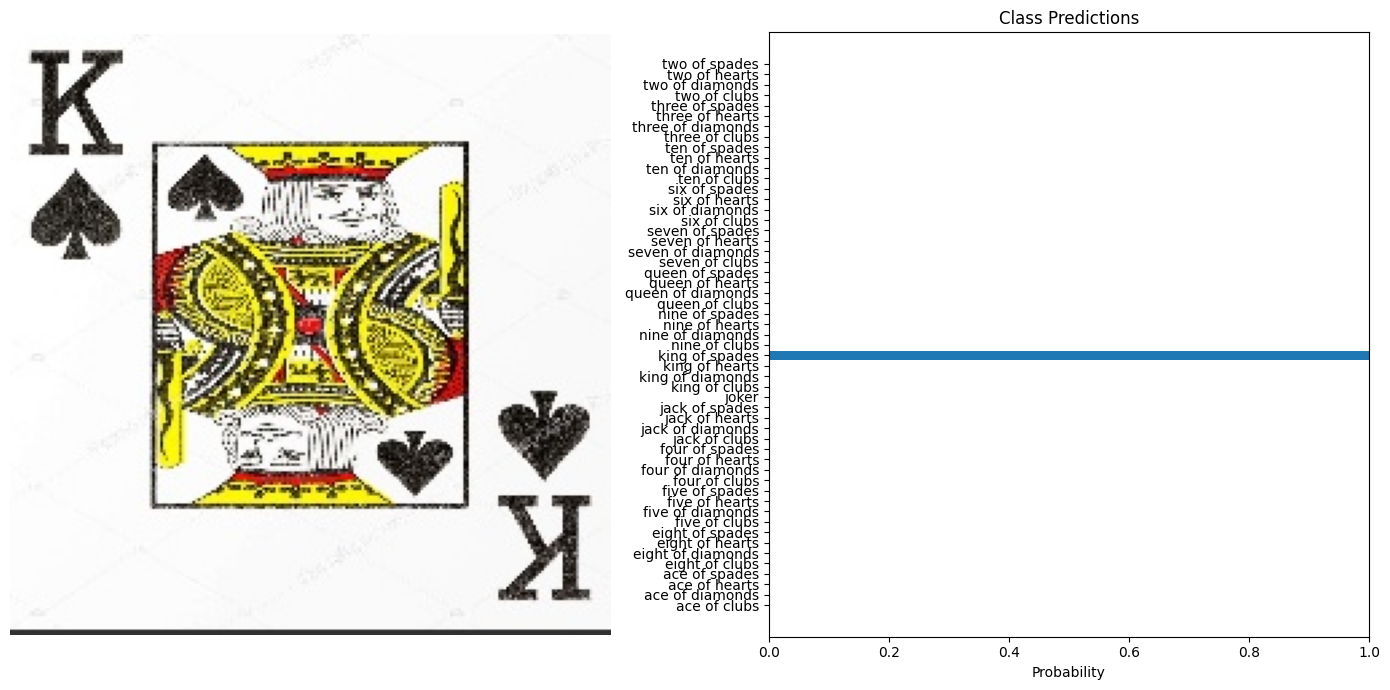

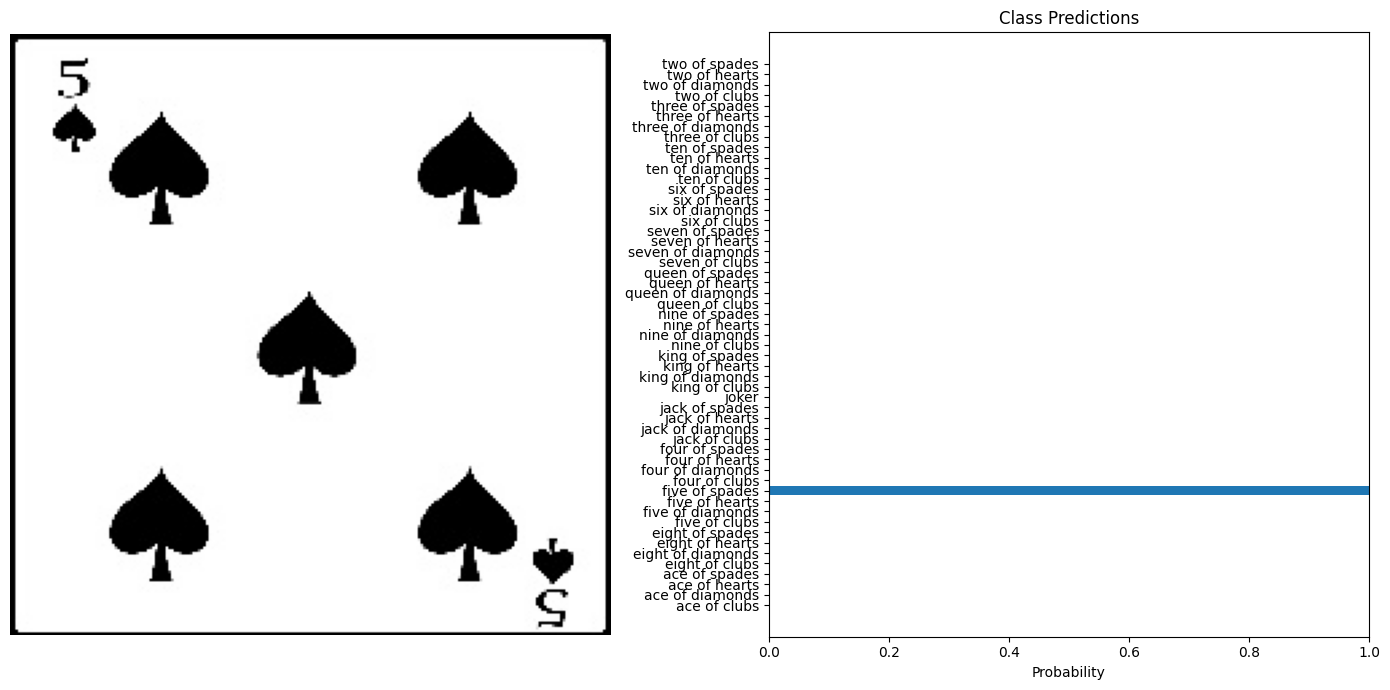

In [67]:
from glob import glob
test_images = glob(f'{test_folder}/*/*')
test_examples = np.random.choice(test_images, 10)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)

    class_names = dataset.classes
    visualize_predictions(original_image, probabilities, class_names)